In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Data Prepration

## 1. Get Data

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and prepare it:
if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"Didn't find {image_path}, directory, gonna download ...")
    image_path.mkdir(parents = True, exist_ok = True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data ...")
        f.write(request.content)

    # Unzip
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data ...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists


In [3]:
# Data Checking

import os
def walk_through_dir(dir_path):
    '''
    Walk through dir path, every of its subdirectories and every images in each subdirectories
    '''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [4]:
?# Setup train and test directory
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

Object `# Setup train and test directory` not found.


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/steak/2017387.jpg
Image class: steak
Image height: 512
Image width: 512


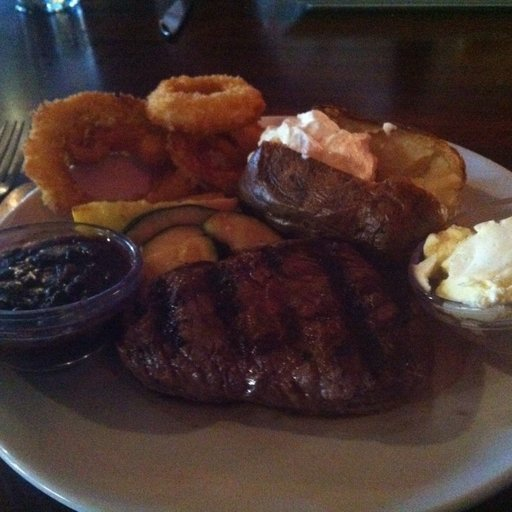

In [5]:
### Visualization
import random
from PIL import Image

random.seed(42)

# 1. Get all image paths (Find all of the find ending in .jpg)
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (Name of the directory where the image is located)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## 2. Data Transformation

Transform Data into Tensor to work in Pytorch.

* torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [7]:
data_transform = transforms.Compose([
    # 1. Resize image from 512 x 512 -> 64 x 64
    transforms.Resize(size = (64, 64)),
    # 2. Flip image randomly on the horizontal
    transforms.RandomHorizontalFlip(p = 0.5), # 50% chance of flip
    # 3. Turn the PIL image into pytorch tensor
    transforms.ToTensor() # This also converts pixel values (0-255 -> 0.0-1.0)
])

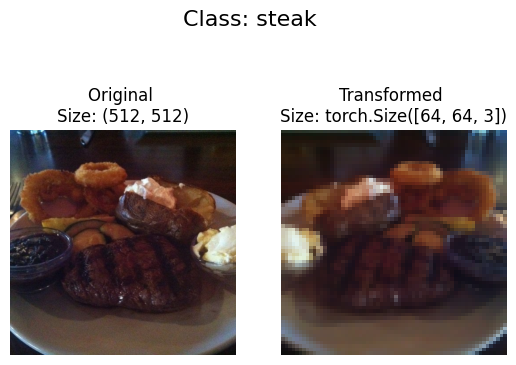

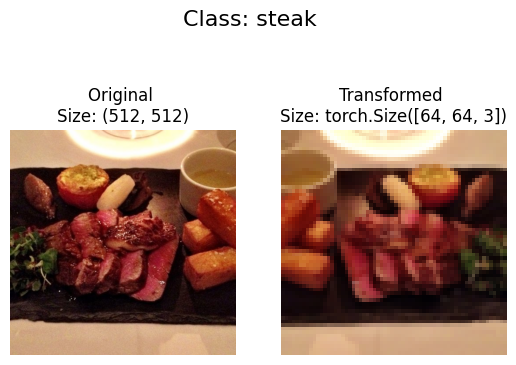

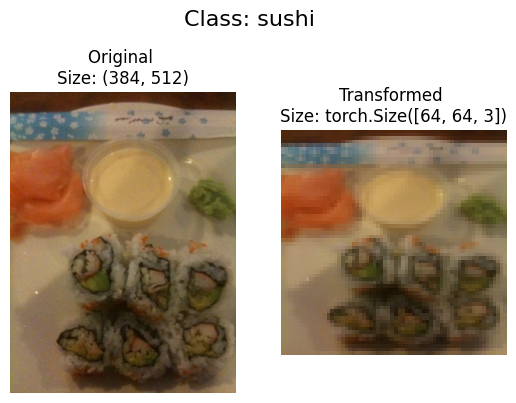

In [8]:
# Visualization

# Plot n random images
def plot_images(image_paths, transform, n = 3, seed = 42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_images(
    image_paths = image_path_list,
    transform = data_transform,
    n = 3
)

In [9]:
### Transform images -> tensor

from torchvision import datasets

train_data = datasets.ImageFolder(
    root = train_dir, # Target folder of images
    transform = data_transform, # Transform images
    target_transform = None # Transform to perform on labels (If necessary)
)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform = data_transform
)

print(f"Train data: \n{train_data}")
print(f"Test data: \n{test_data}")

Train data: 
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data: 
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [10]:
# Get class names as a list and dictionary
print(train_data.classes)
print(train_data.class_to_idx)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [11]:
# Check
print("Size of training / testing set: ", len(train_data), len(test_data))

img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Size of training / testing set:  225 75
Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Text(0.5, 1.0, 'pizza')

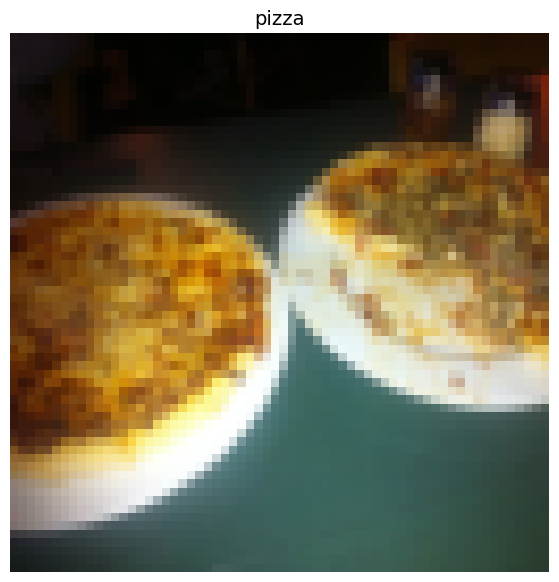

In [12]:
### Plotting an image

# Permute because matplotlib use [height, width, channels], but pytorch use [channels, height, width]
img_permute = img.permute(1, 2, 0)
plt.figure(figsize = (10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(train_data.classes[label], fontsize = 14)

In [13]:
### Turn datasets into multiple batches

from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = 1, # Samples per batch
    num_workers = 1, # How many subprocesses to use for data loading?
    shuffle = True # Shuffle data?
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = 1,
    num_workers = 1,
    shuffle = False
)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [14]:
# Check
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]


## 3. Data Augmentation

In [15]:
from torchvision import transforms

'''
Example Workflow:

  Input Image: A training image (e.g., a 3x224x224 tensor).

  Augmentation:

    Randomly select "rotation" from the operation list.

    Randomly select a magnitude bin (e.g., 15/30 maps to 15° rotation).

  Output: Augmented image with rotation applied.
'''

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    # Randomly picks one way to change the picture (like rotating, shearing, or changing brightness).
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    # Has 31 different “strength levels” to choose from when it changes the picture.
    transforms.ToTensor() # use ToTensor() to get range (0.0, 1.0)
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 46)),
    transforms.ToTensor()
])

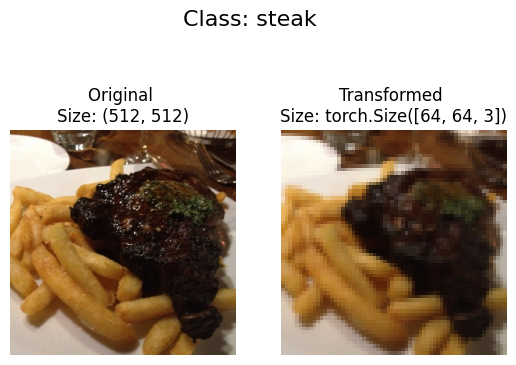

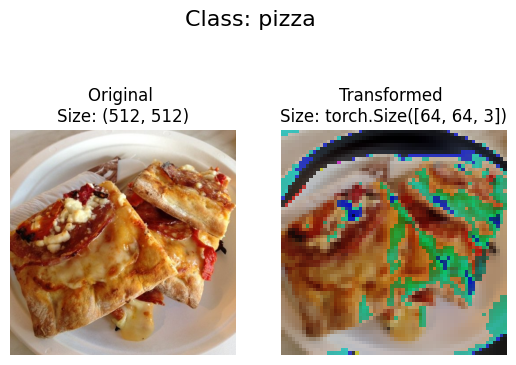

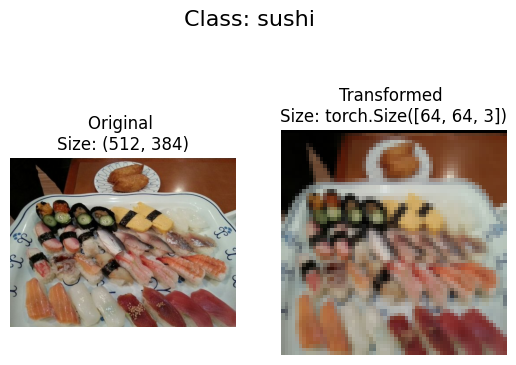

In [16]:
### Plotting transformed images

image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n = 3,
    seed = None
)

# Model 0
- TinyVGG without data augmentation.
- Classify (pizza, steak, sushi)

## 1. Data Prepration

In [17]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [18]:
# 1. Load and Transform Data
from torchvision import datasets, transforms

train_data_simple = datasets.ImageFolder(
    root = train_dir,
    transform = simple_transform,
)

test_data_simple = datasets.ImageFolder(
    root = test_dir,
    transform = simple_transform
)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size: {BATCH_SIZE} and {NUM_WORKERS} workers")

train_dataloader_simple = DataLoader(
    dataset = train_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset = test_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS
)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size: 32 and 2 workers


(<torch.utils.data.dataloader.DataLoader at 0x78ab93cbbad0>,
 <torch.utils.data.dataloader.DataLoader at 0x78ab93ac51d0>)

## 2. Building Model

In [19]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels = input_shape,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features = hidden_units * 16 * 16,
                out_features = output_shape
            )
        )

    def forward(self, x : torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

torch.manual_seed(42)

model_0 = TinyVGG(
    input_shape = 3,
    hidden_units = 10,
    output_shape = len(train_data.classes)
).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [20]:
### Test

# 1. Get a batch of images and labels
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image and unsqueeze to fit the model
img, label = img_batch[0].unsqueeze(dim = 0), label_batch[0]
print(f"Image shape: {img.shape}")

# 3. Forward-pass
model_0.eval()
with torch.inference_mode():
    pred = model_0(img.to(device))

# 4. Check results
print(f"Output_logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim = 1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim = 1))}\n")
print(f"Actual label:\n{label}")

Image shape: torch.Size([1, 3, 64, 64])
Output_logits:
tensor([[0.0578, 0.0634, 0.0351]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
1

Actual label:
2


In [21]:
### Checking shapes through different layers of the model

try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # Do a test pass through of an example input size


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 3. Training and Testing

In [22]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device
):
    model.train()

    train_loss, train_acc = 0, 0

    # Forward a batch (X = [batch_size, color_channels, height, width])
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. Forward-pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Calculate gradients for backward-pass
        loss.backward()

        # 5. Update parameters
        optimizer.step()

        # Calculate accuracy across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        return train_loss, train_acc

In [23]:
def test_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    device: torch.device
):
    model.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # 1. Forward-pass
            y_pred = model(X)

            # 2. Calculate loss/accuracy
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_pred_labels = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

In [24]:
from tqdm.auto import tqdm

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    device: torch.device,
    epochs: int = 5
):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model = model,
            dataloader = train_dataloader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            device = device
        )
        test_loss, test_acc = test_step(
            model = model,
            dataloader = test_dataloader,
            loss_fn = loss_fn,
            device = device
        )

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results

In [25]:
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(
    input_shape = 3,
    hidden_units = 10,
    output_shape = len(train_data.classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params = model_0.parameters(),
    lr = 0.01
)

start_time = timer()

model_0_results = train(
    model = model_0,
    train_dataloader = train_dataloader_simple,
    test_dataloader = test_dataloader_simple,
    optimizer = optimizer,
    loss_fn = loss_fn,
    device = device,
    epochs = NUM_EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1002 | train_acc: 0.2500 | test_loss: 1.2454 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.8323 | train_acc: 0.2812 | test_loss: 1.0293 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1445 | train_acc: 0.2812 | test_loss: 1.2162 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1655 | train_acc: 0.2500 | test_loss: 1.2866 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0889 | train_acc: 0.3438 | test_loss: 1.2814 | test_acc: 0.2604
Total training time: 8.223 seconds


## 4. Plotting

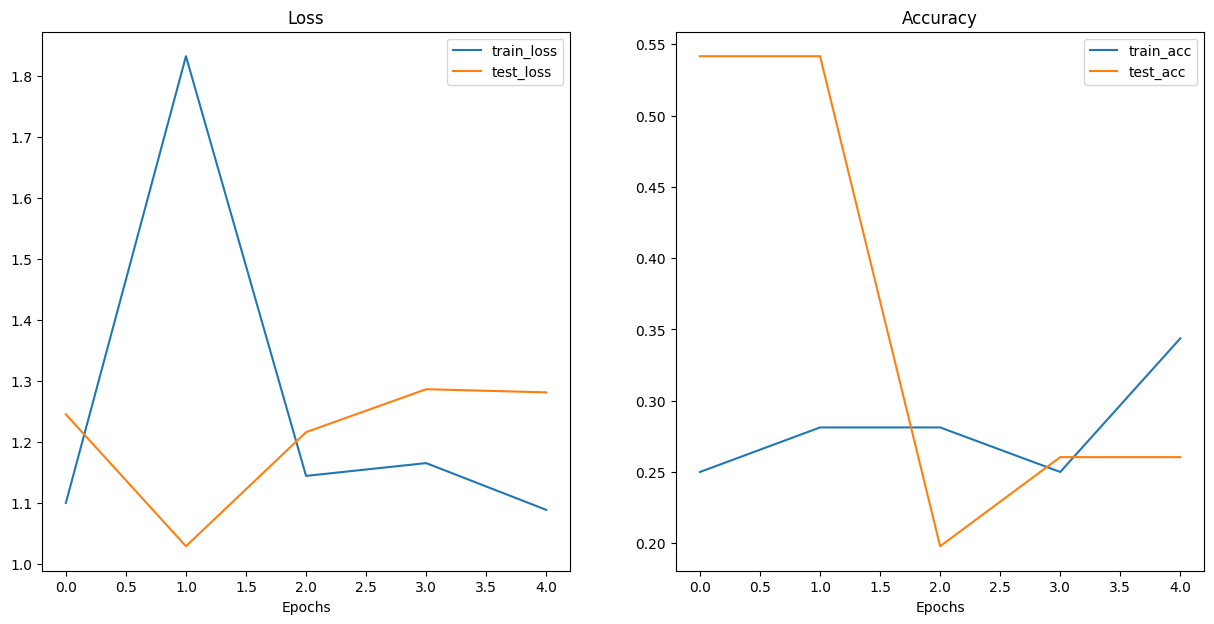

In [26]:
def plot_loss_curves(results: dict[str, list[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize = (15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = 'train_loss')
    plt.plot(epochs, test_loss, label = 'test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = 'train_acc')
    plt.plot(epochs, test_accuracy, label = 'test_acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(model_0_results)

# Model 1

* TinyVGG with data augmentation
* Classify (pizza, steak, sushi)

## 1. Data Preparation

In [27]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [28]:
train_data_augmented = datasets.ImageFolder(
    train_dir,
    transform = train_transform_trivial_augment
)
test_data_simple = datasets.ImageFolder(
    test_dir,
    transform = test_transform
)

In [29]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(
    train_data_augmented,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    test_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS
)

## 2. Building Model

In [30]:
torch.manual_seed(42)

model_1 = TinyVGG(
    input_shape = 3,
    hidden_units = 10,
    output_shape = len(train_data_augmented.classes)
).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 3. Training and Testing

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device = device,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1031 | train_acc: 0.2500 | test_loss: 1.1481 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.4150 | train_acc: 0.4062 | test_loss: 1.0025 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1760 | train_acc: 0.3125 | test_loss: 1.0745 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1286 | train_acc: 0.3438 | test_loss: 1.1448 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0999 | train_acc: 0.3750 | test_loss: 1.1793 | test_acc: 0.2604
Total training time: 10.918 seconds


## 4. Plotting

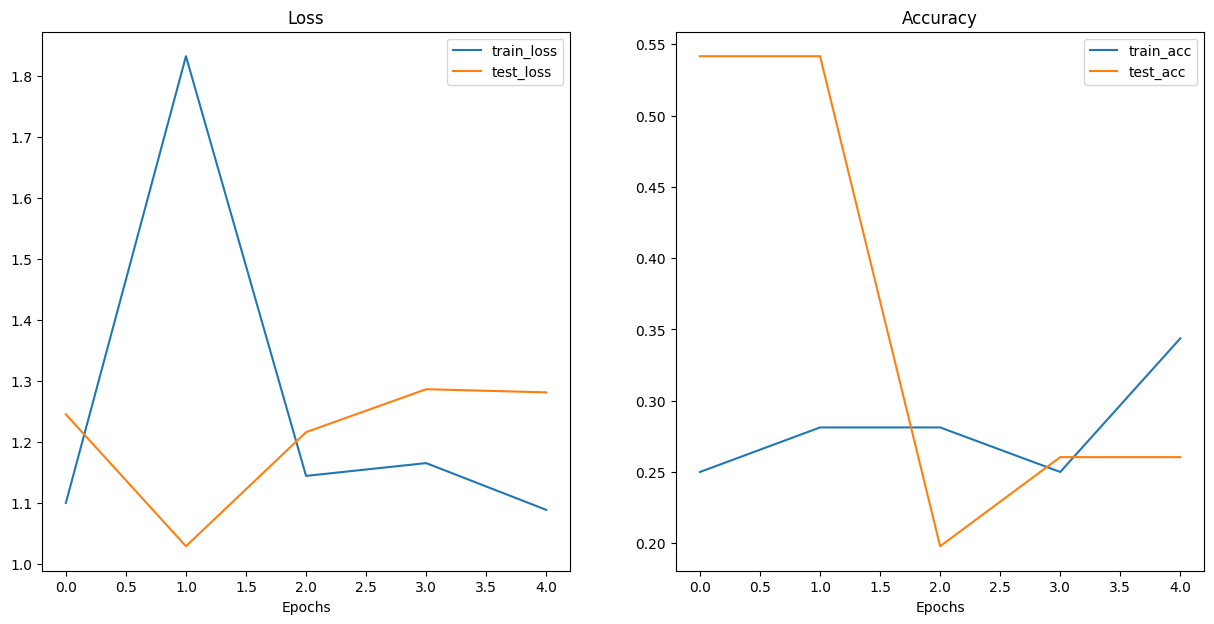

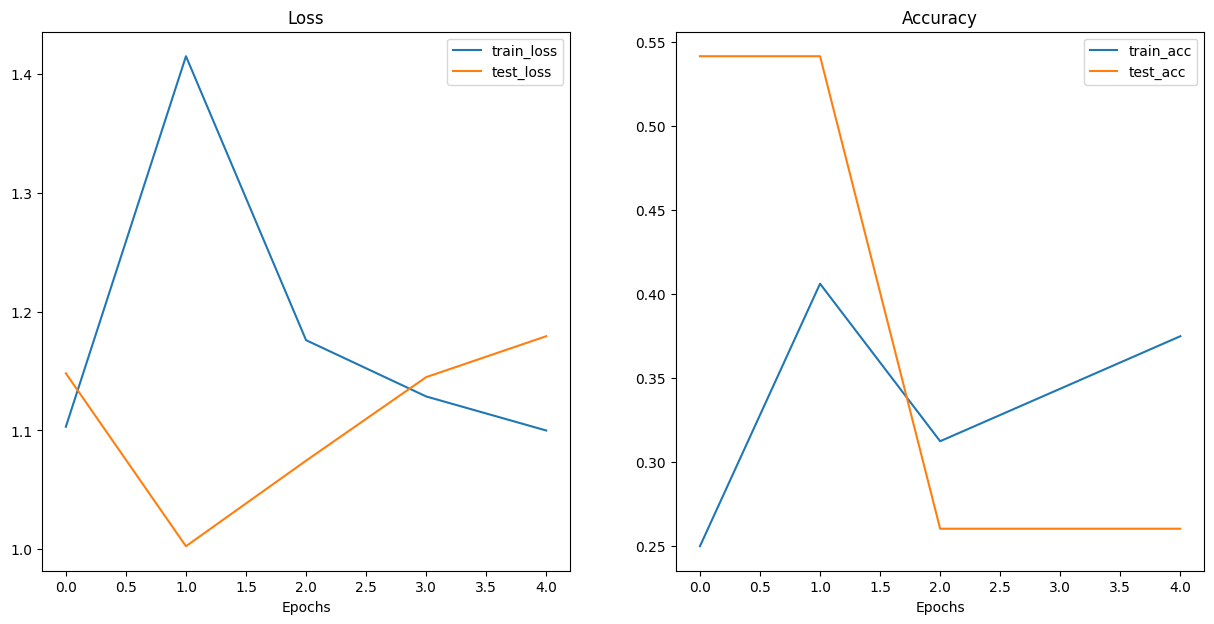

In [32]:
plot_loss_curves(model_0_results)
plot_loss_curves(model_1_results)

# Prediction on Custom Image

In [35]:
### Download custom image

import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists")

In [48]:
### Load the custom image

import torchvision
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.

print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dtype: torch.float32


In [49]:
# Transformation to fit the model

custom_image_transform = transforms.Compose([
    transforms.Resize((64,64))
])

custom_image = custom_image_transform(custom_image)

print(f"New shape: {custom_image.shape}")

New shape: torch.Size([3, 64, 64])


In [50]:
model_1.eval()
with torch.inference_mode():
    # (batch_size, color_channels, height, width)
    custom_image = custom_image.unsqueeze(dim = 0)

    # Logits
    custom_image_pred = model_1(custom_image.to(device))

    # Probability
    custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)

    # Label
    custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim = 1)

    print(f"Custom image pred: {custom_image_pred}")
    print(f"Custom image pred probs: {custom_image_pred_probs}")
    print(f"Custom image pred label: {custom_image_pred_label}")

Custom image pred: tensor([[ 0.2502,  0.0642, -0.1813]])
Custom image pred probs: tensor([[0.4033, 0.3348, 0.2619]])
Custom image pred label: tensor([0])


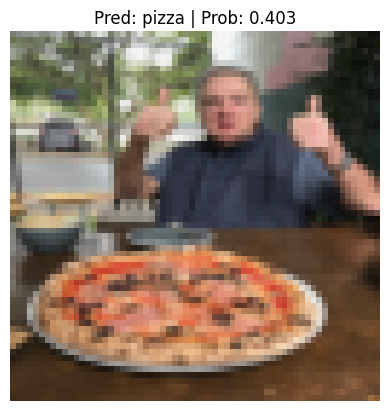

In [51]:
plt.imshow(custom_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib

class_names = train_data.classes
if class_names:
    title = f"Pred: {class_names[custom_image_pred_label.cpu()]} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
else:
    title = f"Pred: {custom_image_pred_label} | Prob: {custom_image_pred_probs.max().cpu():.3f}"

plt.title(title)
plt.axis(False);